<a href="https://colab.research.google.com/github/dominiksakic/zero_to_hero/blob/main/basics_04_activations_and_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-06-23 09:17:46--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.004s  

2025-06-23 09:17:46 (50.7 MB/s) - ‘names.txt’ saved [228145/228145]



In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [6]:
# build vocab and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}
vocab_size = len(itos)

In [5]:
# build the dataset
block_size = 3

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [15]:
n_embd = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]

In [16]:
total_param = sum(p.nelement() for p in parameters)
print(f"Total params: {total_param}")

for p in parameters:
  p.requires_grad = True

Total params: 11897


In [17]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact  = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats, lri for finding a good lr
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.9415
  20000/ 200000: 2.5069
  30000/ 200000: 2.7998
  40000/ 200000: 2.0261
  50000/ 200000: 2.5863
  60000/ 200000: 2.3420
  70000/ 200000: 2.0952
  80000/ 200000: 2.3454
  90000/ 200000: 2.2365
 100000/ 200000: 2.1080
 110000/ 200000: 2.3831
 120000/ 200000: 1.9898
 130000/ 200000: 2.4591
 140000/ 200000: 2.1910
 150000/ 200000: 2.1606
 160000/ 200000: 2.1811
 170000/ 200000: 1.7997
 180000/ 200000: 2.0962
 190000/ 200000: 1.8052


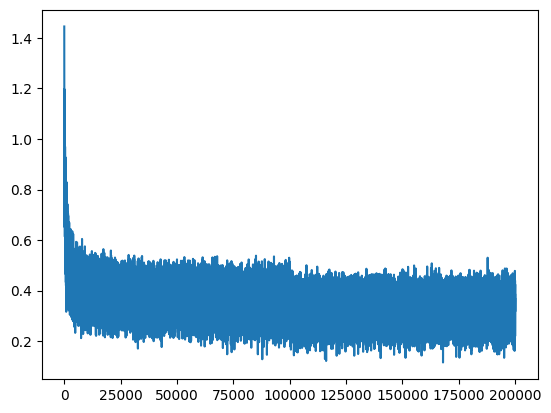

In [18]:
plt.plot(lossi)

In [23]:
@torch.no_grad()
def calculate_loss(X, Y):
  emb = C[X]
  embcat =  emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  return loss.item()

In [24]:
# training loss
train_loss = calculate_loss(Xtr, Ytr)
train_loss

2.127678871154785

In [25]:
# validation loss
dev_loss = calculate_loss(Xdev, Ydev)
dev_loss

2.1750576496124268

In [26]:
# test loss
test_loss = calculate_loss(Xte, Yte)
test_loss

2.1674134731292725

# Exploring the Network initialization
- The first loss recorded is quite high: 27
- If we had a uniform distribution of the next letter, we would expect each letter to have the same out come: 1/27. The loss would equal to something around 3.2. (Take the neg likelihood of 1/27)
- Question:
  - Can we achieve the first loss to be 3.2, or asked differently, what values do the layers have to be initialized to, so that we have a Uniform distribution?

In [36]:
n_embd = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

- Initializing the W2 to excatly 0 can lead to Neuron damage(see below)

In [37]:
total_param = sum(p.nelement() for p in parameters)
print(f"Total params: {total_param}")

for p in parameters:
  p.requires_grad = True

Total params: 11897


In [39]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact  = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats, lri for finding a good lr
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())


      0/ 200000: 3.1857
  10000/ 200000: 1.8700
  20000/ 200000: 1.9252
  30000/ 200000: 2.0570
  40000/ 200000: 2.2073
  50000/ 200000: 2.1325
  60000/ 200000: 2.1533
  70000/ 200000: 2.8029
  80000/ 200000: 2.6544
  90000/ 200000: 2.2931
 100000/ 200000: 2.2813
 110000/ 200000: 1.8629
 120000/ 200000: 2.1695
 130000/ 200000: 1.9693
 140000/ 200000: 1.8043
 150000/ 200000: 2.4483
 160000/ 200000: 2.2238
 170000/ 200000: 1.7788
 180000/ 200000: 1.9207
 190000/ 200000: 2.1601


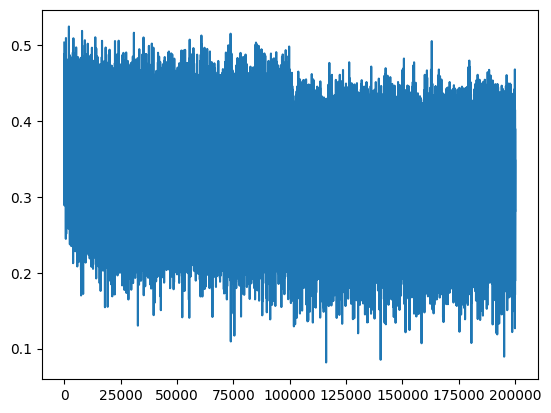

In [40]:
plt.plot(lossi)

In [41]:
# training loss
train_loss = calculate_loss(Xtr, Ytr)
print(f"Training loss: {train_loss}")
# validation loss
dev_loss = calculate_loss(Xdev, Ydev)
print(f"Dev loss: {dev_loss}")
# test loss
test_loss = calculate_loss(Xte, Yte)
print(f"Test loss: {test_loss}")

Training loss: 2.0695769786834717
Dev loss: 2.131199598312378
Test loss: 2.132943868637085


# Exploring the activation of the hidden layers!
- squashing the values, can lead to a lot of 0, or 1 -> Which can lead to Dead neuron for the tanh.
- Think about it from the backward pass. Starting from the loss, you flow backwards to the tanh. Than if you have values of -1 or 1 than you kill the Gradient flowing backward. -> Meaning the Gradient stops at the tanh Neuron and all the other Neurons cannot be optimized. (See below for vizulization)


In [42]:
n_embd = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

In [43]:
total_param = sum(p.nelement() for p in parameters)
print(f"Total params: {total_param}")

for p in parameters:
  p.requires_grad = True

Total params: 11897


In [44]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact  = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats, lri for finding a good lr
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())
  break

      0/ 200000: 3.3221


(array([2069.,  144.,  106.,   82.,   59.,   56.,   44.,   30.,   43.,
          26.,   16.,   38.,   16.,   32.,   24.,   14.,   28.,   27.,
          26.,   19.,   24.,   26.,   30.,   14.,   19.,   19.,   22.,
          26.,   18.,   12.,   10.,   33.,   27.,   32.,   17.,   24.,
          30.,   22.,   26.,   29.,   26.,   40.,   29.,   41.,   49.,
          64.,   62.,  100.,  188., 2442.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

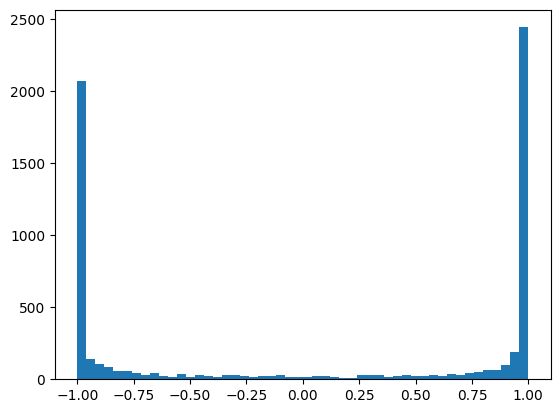

In [49]:
plt.hist(h.view(-1).tolist(), 50)

(array([  2.,   2.,   1.,   4.,   2.,   4.,   6.,  15.,   5.,  25.,  32.,
         49.,  56.,  59.,  92., 119., 134., 197., 195., 221., 257., 275.,
        297., 341., 353., 375., 369., 349., 358., 362., 271., 312., 229.,
        206., 190., 167.,  87., 111.,  72.,  55.,  41.,  22.,  23.,  18.,
         17.,   8.,   5.,   7.,   2.,   1.]),
 array([-19.05793571, -18.31571732, -17.57349892, -16.83128052,
        -16.08906212, -15.34684372, -14.60462532, -13.86240692,
        -13.12018852, -12.37797012, -11.63575172, -10.89353333,
        -10.15131493,  -9.40909653,  -8.66687813,  -7.92465973,
         -7.18244133,  -6.44022293,  -5.69800453,  -4.95578613,
         -4.21356773,  -3.47134933,  -2.72913094,  -1.98691254,
         -1.24469414,  -0.50247574,   0.23974266,   0.98196106,
          1.72417946,   2.46639786,   3.20861626,   3.95083466,
          4.69305305,   5.43527145,   6.17748985,   6.91970825,
          7.66192665,   8.40414505,   9.14636345,   9.88858185,
         10.630800

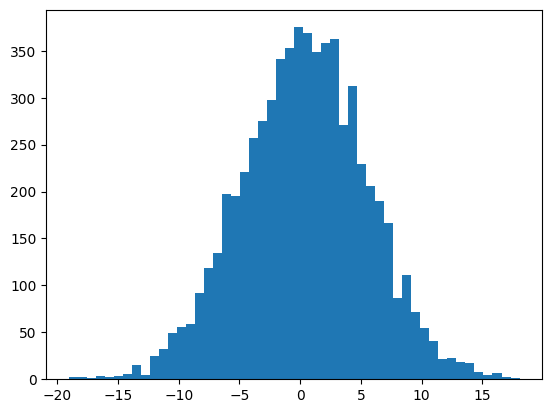

In [51]:
plt.hist(hpreact.view(-1).tolist(), 50)

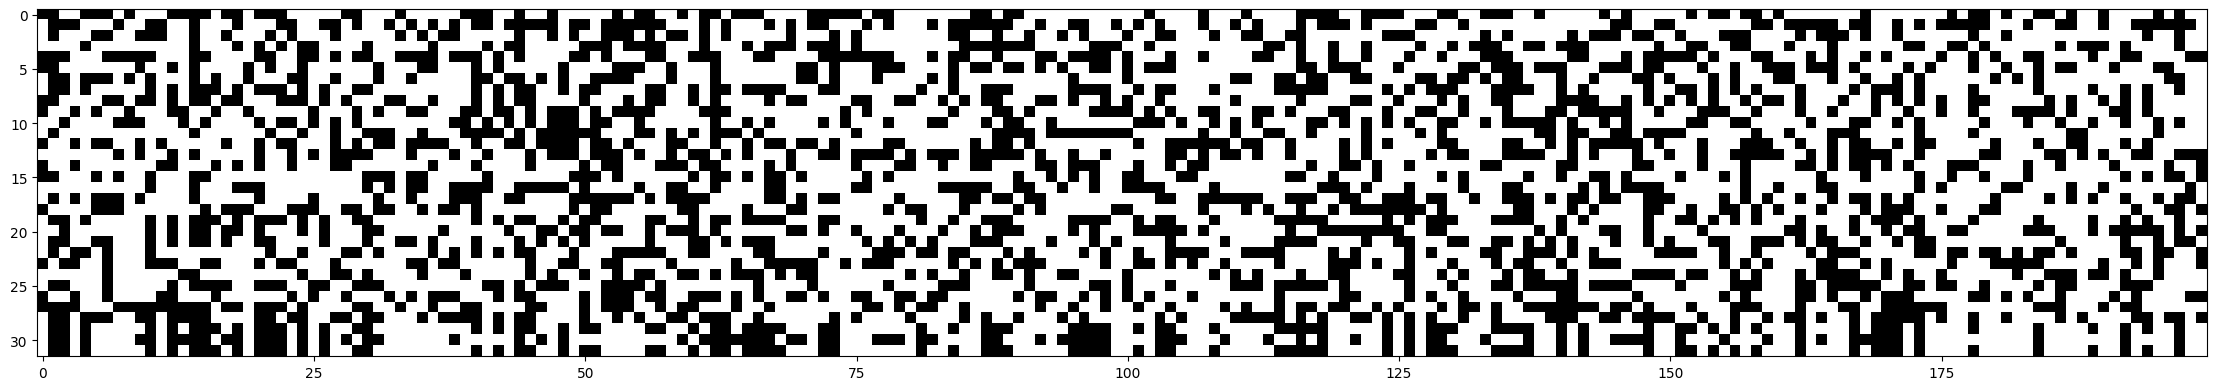

In [55]:
plt.figure(figsize=(28,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

- High activation (> 0.99) gets marked as white
- If at any x-achses you find a strip of pure white, that would mean a unreachable Neuron.
- This can be caused by bad initialization or a too high learning rate, that knocks out Neurons in the backward pass.

In [68]:
n_embd = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2  #<--
b1 = torch.randn(n_hidden,                        generator=g) * 0    #<--
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

In [69]:
total_param = sum(p.nelement() for p in parameters)
print(f"Total params: {total_param}")

for p in parameters:
  p.requires_grad = True

Total params: 11897


In [70]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact  = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats, lri for finding a good lr
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())
  break

      0/ 200000: 3.3134


(array([140., 172., 169., 160., 144., 154., 135., 128., 108., 142.,  93.,
        103., 131., 109., 118.,  95.,  81., 102., 104., 106., 106., 123.,
        109.,  73., 107., 112., 100., 106., 101.,  97., 106., 123., 111.,
        125.,  95., 142., 101.,  98., 123., 122., 141., 125., 165., 161.,
        163., 185., 187., 197., 212., 190.]),
 array([-9.98918831e-01, -9.58983165e-01, -9.19047499e-01, -8.79111832e-01,
        -8.39176166e-01, -7.99240500e-01, -7.59304833e-01, -7.19369167e-01,
        -6.79433501e-01, -6.39497834e-01, -5.99562168e-01, -5.59626502e-01,
        -5.19690835e-01, -4.79755169e-01, -4.39819503e-01, -3.99883837e-01,
        -3.59948170e-01, -3.20012504e-01, -2.80076838e-01, -2.40141171e-01,
        -2.00205505e-01, -1.60269839e-01, -1.20334172e-01, -8.03985059e-02,
        -4.04628396e-02, -5.27173281e-04,  3.94084930e-02,  7.93441594e-02,
         1.19279826e-01,  1.59215492e-01,  1.99151158e-01,  2.39086825e-01,
         2.79022491e-01,  3.18958157e-01,  3.58893

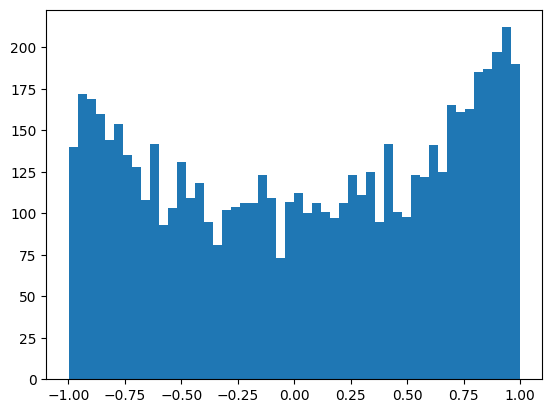

In [71]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   2.,   0.,   1.,   5.,   3.,  11.,   6.,  13.,  10.,  25.,
         40.,  39.,  77.,  64.,  99., 134., 169., 187., 219., 224., 275.,
        308., 311., 355., 369., 379., 357., 366., 333., 292., 284., 287.,
        244., 187., 170., 134., 104.,  82.,  74.,  41.,  30.,  27.,  19.,
         12.,   7.,  12.,   3.,   2.,   7.]),
 array([-3.76114893, -3.61751465, -3.47388037, -3.33024609, -3.1866118 ,
        -3.04297752, -2.89934324, -2.75570896, -2.61207468, -2.4684404 ,
        -2.32480612, -2.18117184, -2.03753756, -1.89390327, -1.75026899,
        -1.60663471, -1.46300043, -1.31936615, -1.17573187, -1.03209759,
        -0.88846331, -0.74482903, -0.60119474, -0.45756046, -0.31392618,
        -0.1702919 , -0.02665762,  0.11697666,  0.26061094,  0.40424522,
         0.54787951,  0.69151379,  0.83514807,  0.97878235,  1.12241663,
         1.26605091,  1.40968519,  1.55331947,  1.69695375,  1.84058804,
         1.98422232,  2.1278566 ,  2.27149088,  2.41512516,  2.55875944,
 

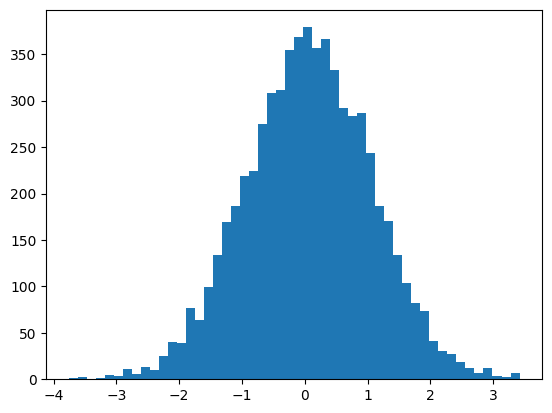

In [74]:
plt.hist(hpreact.view(-1).tolist(), 50)

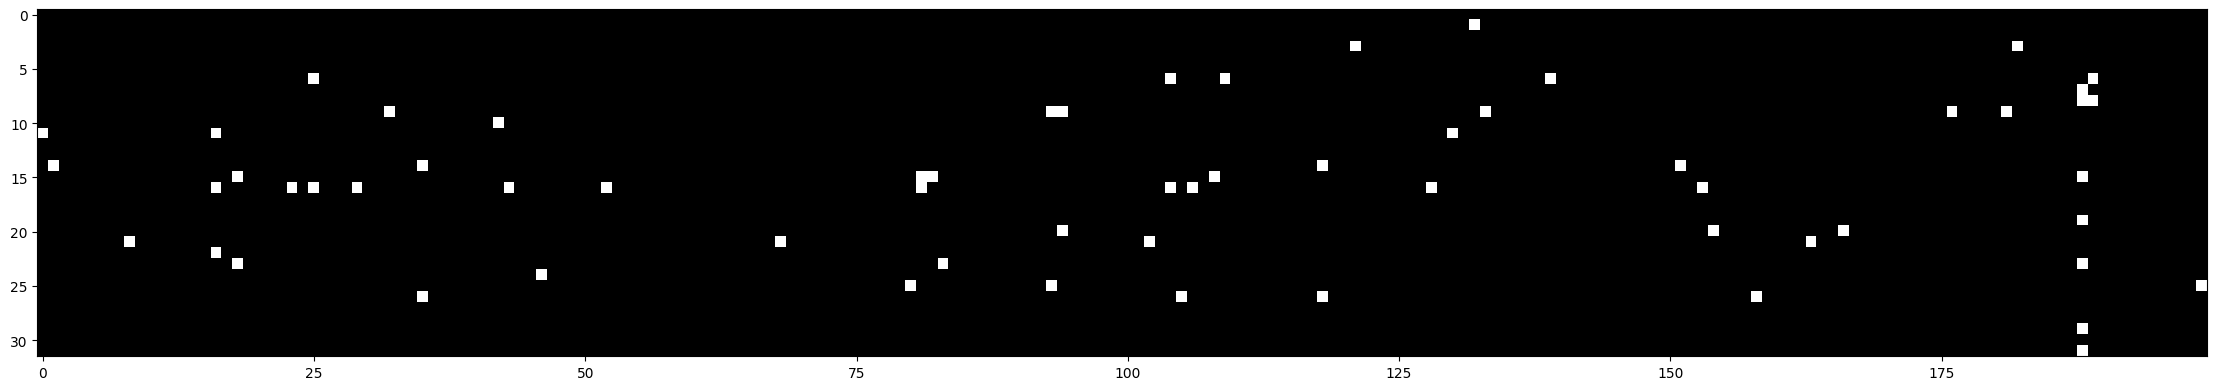

In [73]:
plt.figure(figsize=(28,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# Experiment Initialize to Zero and Visualize the Activations.

In [87]:
n_embd = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0 #<--
b1 = torch.randn(n_hidden,                        generator=g) * 0 #<--
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0 #<--
b2 = torch.randn(vocab_size,                      generator=g) * 0 #<--

parameters = [C, W1, b1, W2, b2]


total_param = sum(p.nelement() for p in parameters)
print(f"Total params: {total_param}")

for p in parameters:
  p.requires_grad = True

  max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact  = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats, lri for finding a good lr
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

Total params: 11897
      0/ 200000: 3.2958
  10000/ 200000: 2.6793
  20000/ 200000: 2.8210
  30000/ 200000: 3.0941
  40000/ 200000: 3.0673
  50000/ 200000: 3.0884
  60000/ 200000: 2.8090
  70000/ 200000: 2.6637
  80000/ 200000: 2.6951
  90000/ 200000: 2.7917
 100000/ 200000: 2.5930
 110000/ 200000: 3.0857
 120000/ 200000: 2.8063
 130000/ 200000: 2.8613
 140000/ 200000: 2.8347
 150000/ 200000: 2.8381
 160000/ 200000: 2.8990
 170000/ 200000: 2.6623
 180000/ 200000: 2.7992
 190000/ 200000: 2.8359


(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0., 6400.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
        -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
        -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
         0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
         0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
         0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]),
 <BarContainer object of 50 artists>)

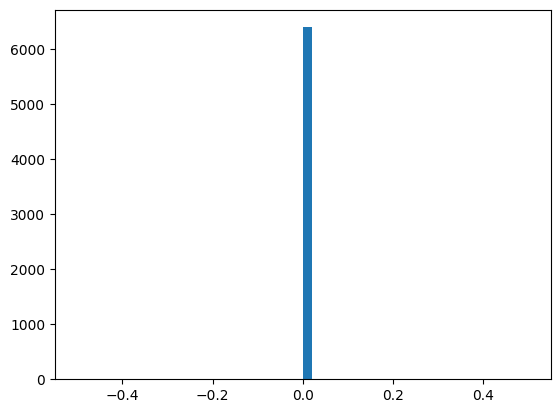

In [88]:
plt.hist(h.view(-1).tolist(), 50)

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0., 6400.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
        -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
        -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
         0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
         0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
         0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]),
 <BarContainer object of 50 artists>)

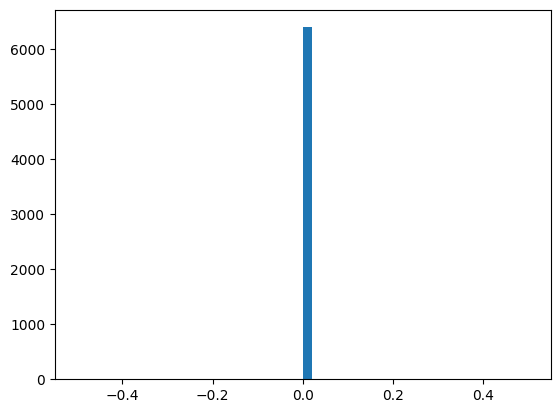

In [89]:
plt.hist(hpreact.view(-1).tolist(), 50)

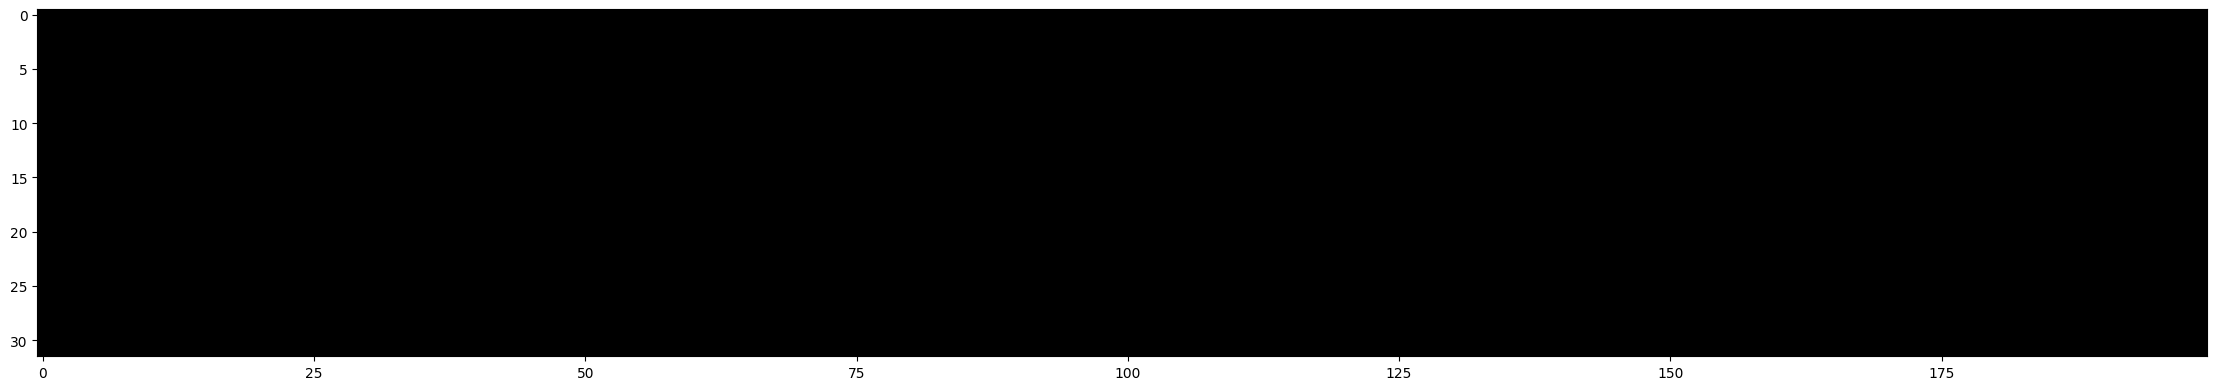

In [93]:
plt.figure(figsize=(28,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [91]:
# training loss
train_loss = calculate_loss(Xtr, Ytr)
print(f"Training loss: {train_loss}")
# validation loss
dev_loss = calculate_loss(Xdev, Ydev)
print(f"Dev loss: {dev_loss}")
# test loss
test_loss = calculate_loss(Xte, Yte)
print(f"Test loss: {test_loss}")

Training loss: 2.822659730911255
Dev loss: 2.8209733963012695
Test loss: 2.8255531787872314


# Setting initialization
- no magic number is the goal!
- See below how the std is changing after doing a multiplication, we want the std to stay the same.
- Further reading: https://arxiv.org/pdf/1502.01852
- practical use: https://docs.pytorch.org/docs/stable/nn.init.html

tensor(0.0113) tensor(0.9823)
tensor(0.0581) tensor(1.8173)


(array([6.22009595e-05, 1.08851679e-04, 2.64354078e-04, 5.59808635e-04,
        9.33014392e-04, 2.03708142e-03, 3.12559358e-03, 4.75838046e-03,
        7.52630494e-03, 1.17093480e-02, 1.68097968e-02, 2.46004612e-02,
        3.60610063e-02, 4.60598105e-02, 6.22165097e-02, 7.91040702e-02,
        1.00050243e-01, 1.22147134e-01, 1.44617231e-01, 1.66449768e-01,
        1.90832544e-01, 2.07906707e-01, 2.22492832e-01, 2.30594165e-01,
        2.24872352e-01, 2.13426726e-01, 1.93585223e-01, 1.73447118e-01,
        1.49142572e-01, 1.20234276e-01, 9.34881808e-02, 7.18420017e-02,
        5.29795887e-02, 3.85646521e-02, 2.89389535e-02, 2.06974000e-02,
        1.51459112e-02, 1.08074327e-02, 7.68180711e-03, 4.91388309e-03,
        3.71650182e-03, 2.13038602e-03, 1.32176843e-03, 1.04186762e-03,
        4.82056721e-04, 2.33253944e-04, 1.86602602e-04, 1.08851518e-04,
        1.55502629e-05, 1.55503091e-05]),
 array([-7.46571064, -7.14417219, -6.82263374, -6.50109529, -6.17955685,
        -5.8580184 , 

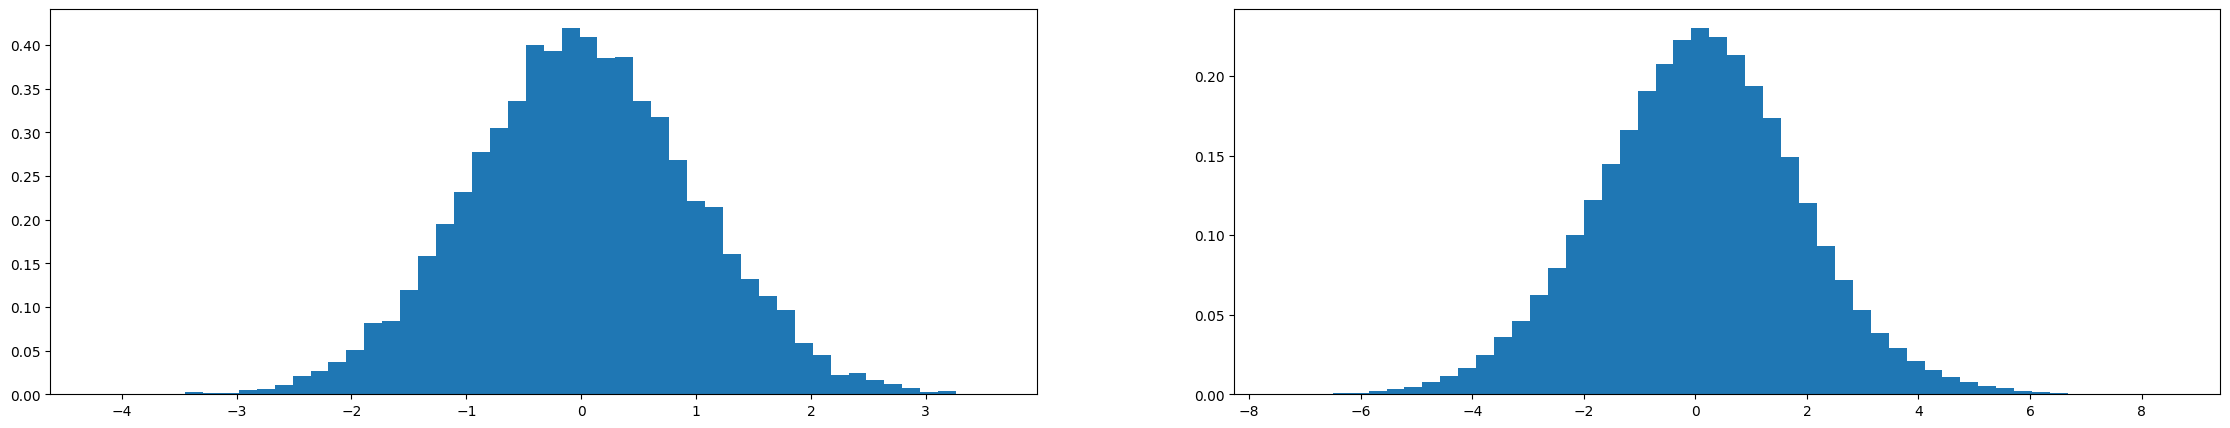

In [102]:
x = torch.randn(1000, 10)
w = torch.rand(10, 200) # <-- What do we multiply it with to keep the std?
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(28, 5))
plt.subplot(121)
plt.hist(x.view(-1), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1), 50, density=True)

tensor(-0.0021) tensor(1.0040)
tensor(-0.0008) tensor(0.1236)


(array([6.33602997e-04, 4.22400935e-04, 1.05600500e-03, 2.95681026e-03,
        4.85761686e-03, 8.02562786e-03, 1.43616499e-02, 2.74561299e-02,
        4.41408977e-02, 7.24419427e-02, 1.19117214e-01, 1.76775014e-01,
        2.71604143e-01, 3.85230622e-01, 5.54613125e-01, 7.31599340e-01,
        9.81449807e-01, 1.27565243e+00, 1.62814850e+00, 2.05097032e+00,
        2.43725646e+00, 2.74603193e+00, 3.06009127e+00, 3.29134808e+00,
        3.33359657e+00, 3.21975112e+00, 3.00686862e+00, 2.71731205e+00,
        2.36797964e+00, 1.96290208e+00, 1.58970592e+00, 1.23341383e+00,
        9.27383587e-01, 6.77953500e-01, 4.63163791e-01, 3.15955899e-01,
        2.14157813e-01, 1.34112634e-01, 7.81441729e-02, 4.75202248e-02,
        2.64000584e-02, 1.68960799e-02, 8.23681822e-03, 5.91362797e-03,
        3.16801499e-03, 1.68960799e-03, 6.33599807e-04, 2.11200999e-04,
        4.22401998e-04, 4.22400935e-04]),
 array([-0.57686359, -0.55318946, -0.52951527, -0.50584114, -0.48216698,
        -0.45849282, 

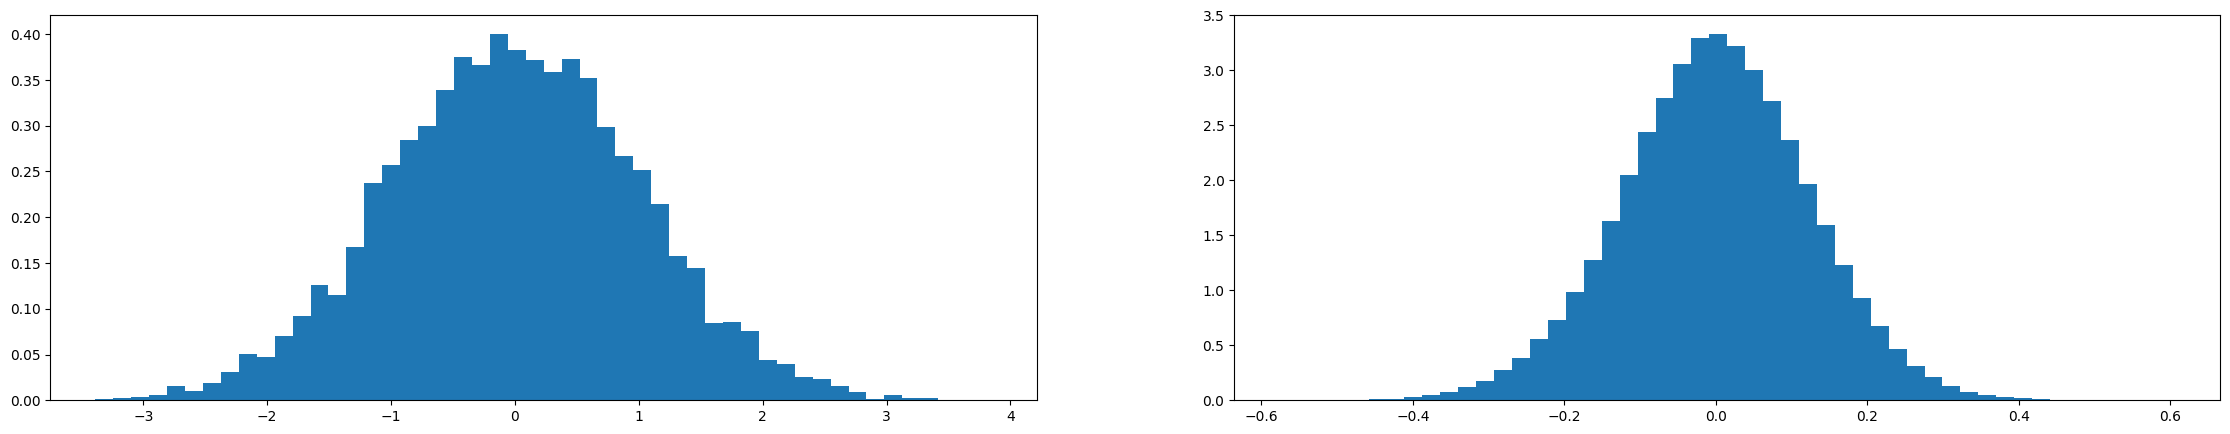

In [105]:
x = torch.randn(1000, 10)
w = torch.rand(10, 200) / 10 ** 0.5 # This is depending on the operation done read paper, docu.
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(28, 5))
plt.subplot(121)
plt.hist(x.view(-1), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1), 50, density=True)